# **Load Packages**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

# **Load Data**
* 数据参照原始论文提供的预处理代码，已使用stata进行清洗
* treatment: guest_black
* outcome: yes
* control:

In [2]:
data = pd.read_csv('processed_data.csv')

In [3]:
# 返回data[["yes","host_response"]]中yes是nan的行
data[data["yes"].isnull()][["yes","host_response"]]["host_response"].value_counts()

host_response
Message not sent             125
Offers a different place      26
Confused (our date error)      4
Name: count, dtype: int64

In [4]:
data = data.dropna(subset=["yes"])
data.reset_index(drop=True, inplace=True)
data

,host_response,response_date,number_of_messages,automated_coding,latitude,longitude,bed_type,property_type,cancellation_policy,number_guests,...,los_angeles,sl,dc,total_guests,raw_black,prop_black,any_black,past_guest_merge,filled_september,pr_filled
0,Yes,2015-07-19 08:26:17,2.0,1.0,34.0815,-118.2700,Real Bed,House,Flexible,3.0,...,1,0,0,11.0,0.0,0.000000,0.0,matched (3),1,0.412335
1,No or unavailable,2015-07-14 14:13:39,NaN,1.0,38.9107,-77.0198,NaN,House,Moderate,2.0,...,0,0,1,167.0,0.0,0.000000,0.0,matched (3),1,0.686212
2,Request for more info (Can you verify? How man...,2015-07-20 16:24:08,2.0,0.0,34.0047,-118.4810,Pull-out Sofa,Apartment,Strict,1.0,...,1,0,0,19.0,0.0,0.000000,0.0,matched (3),0,0.330621
3,I will get back to you,2015-07-20 06:47:38,NaN,0.0,34.0917,-118.2820,NaN,House,Strict,8.0,...,1,0,0,41.0,0.0,0.000000,0.0,matched (3),0,0.535649
4,"Yes, if you verify/give more info",2015-07-18 18:07:19,NaN,0.0,34.0809,-118.3670,NaN,Apartment,Strict,3.0,...,1,0,0,263.0,1.0,0.003802,1.0,matched (3),1,0.855355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6230,Yes,2015-07-17 04:14:30,2.0,0.0,34.1737,-118.3440,Real Bed,House,Flexible,2.0,...,1,0,0,19.0,0.0,0.000000,0.0,matched (3),1,0.366860
6231,Check back later for definitive answer,2015-07-21 00:48:13,NaN,0.0,34.0428,-118.5620,NaN,House,Strict,9.0,...,1,0,0,NaN,0.0,0.000000,0.0,master only (1),0,0.292540
6232,Request for more info (Can you verify? How man...,2015-07-20 21:52:09,2.0,0.0,33.8766,-118.4020,NaN,Apartment,Flexible,6.0,...,1,0,0,6.0,0.0,0.000000,0.0,matched (3),0,0.396052
6233,Yes,2015-07-17 19:03:08,6.0,0.0,33.8679,-117.9230,NaN,House,Strict,4.0,...,1,0,0,10.0,1.0,0.100000,1.0,matched (3),1,0.323459


# **Problem 2**
> Let’s first focus on learning the average treatment effect of the treatment on the outcome of
your choice. 


---------------
## **(a)**
* Describe `conditions/assumptions` under which the average treatment effect can be identified from the observed data,      
* and discuss whether the conditions/assumptions are `plausible` for the data you chose.
---------------

---------------
## **(b)**
* Apply the simple `difference-in-mean` estimator and `linear regressions` to estimate the average treatment effect.     
* Report the `confidence interval` and `hypothesis testing results` for the
average treatment effect.      
* Are these valid ways to estimate the average treatment effect? Why?
---------------

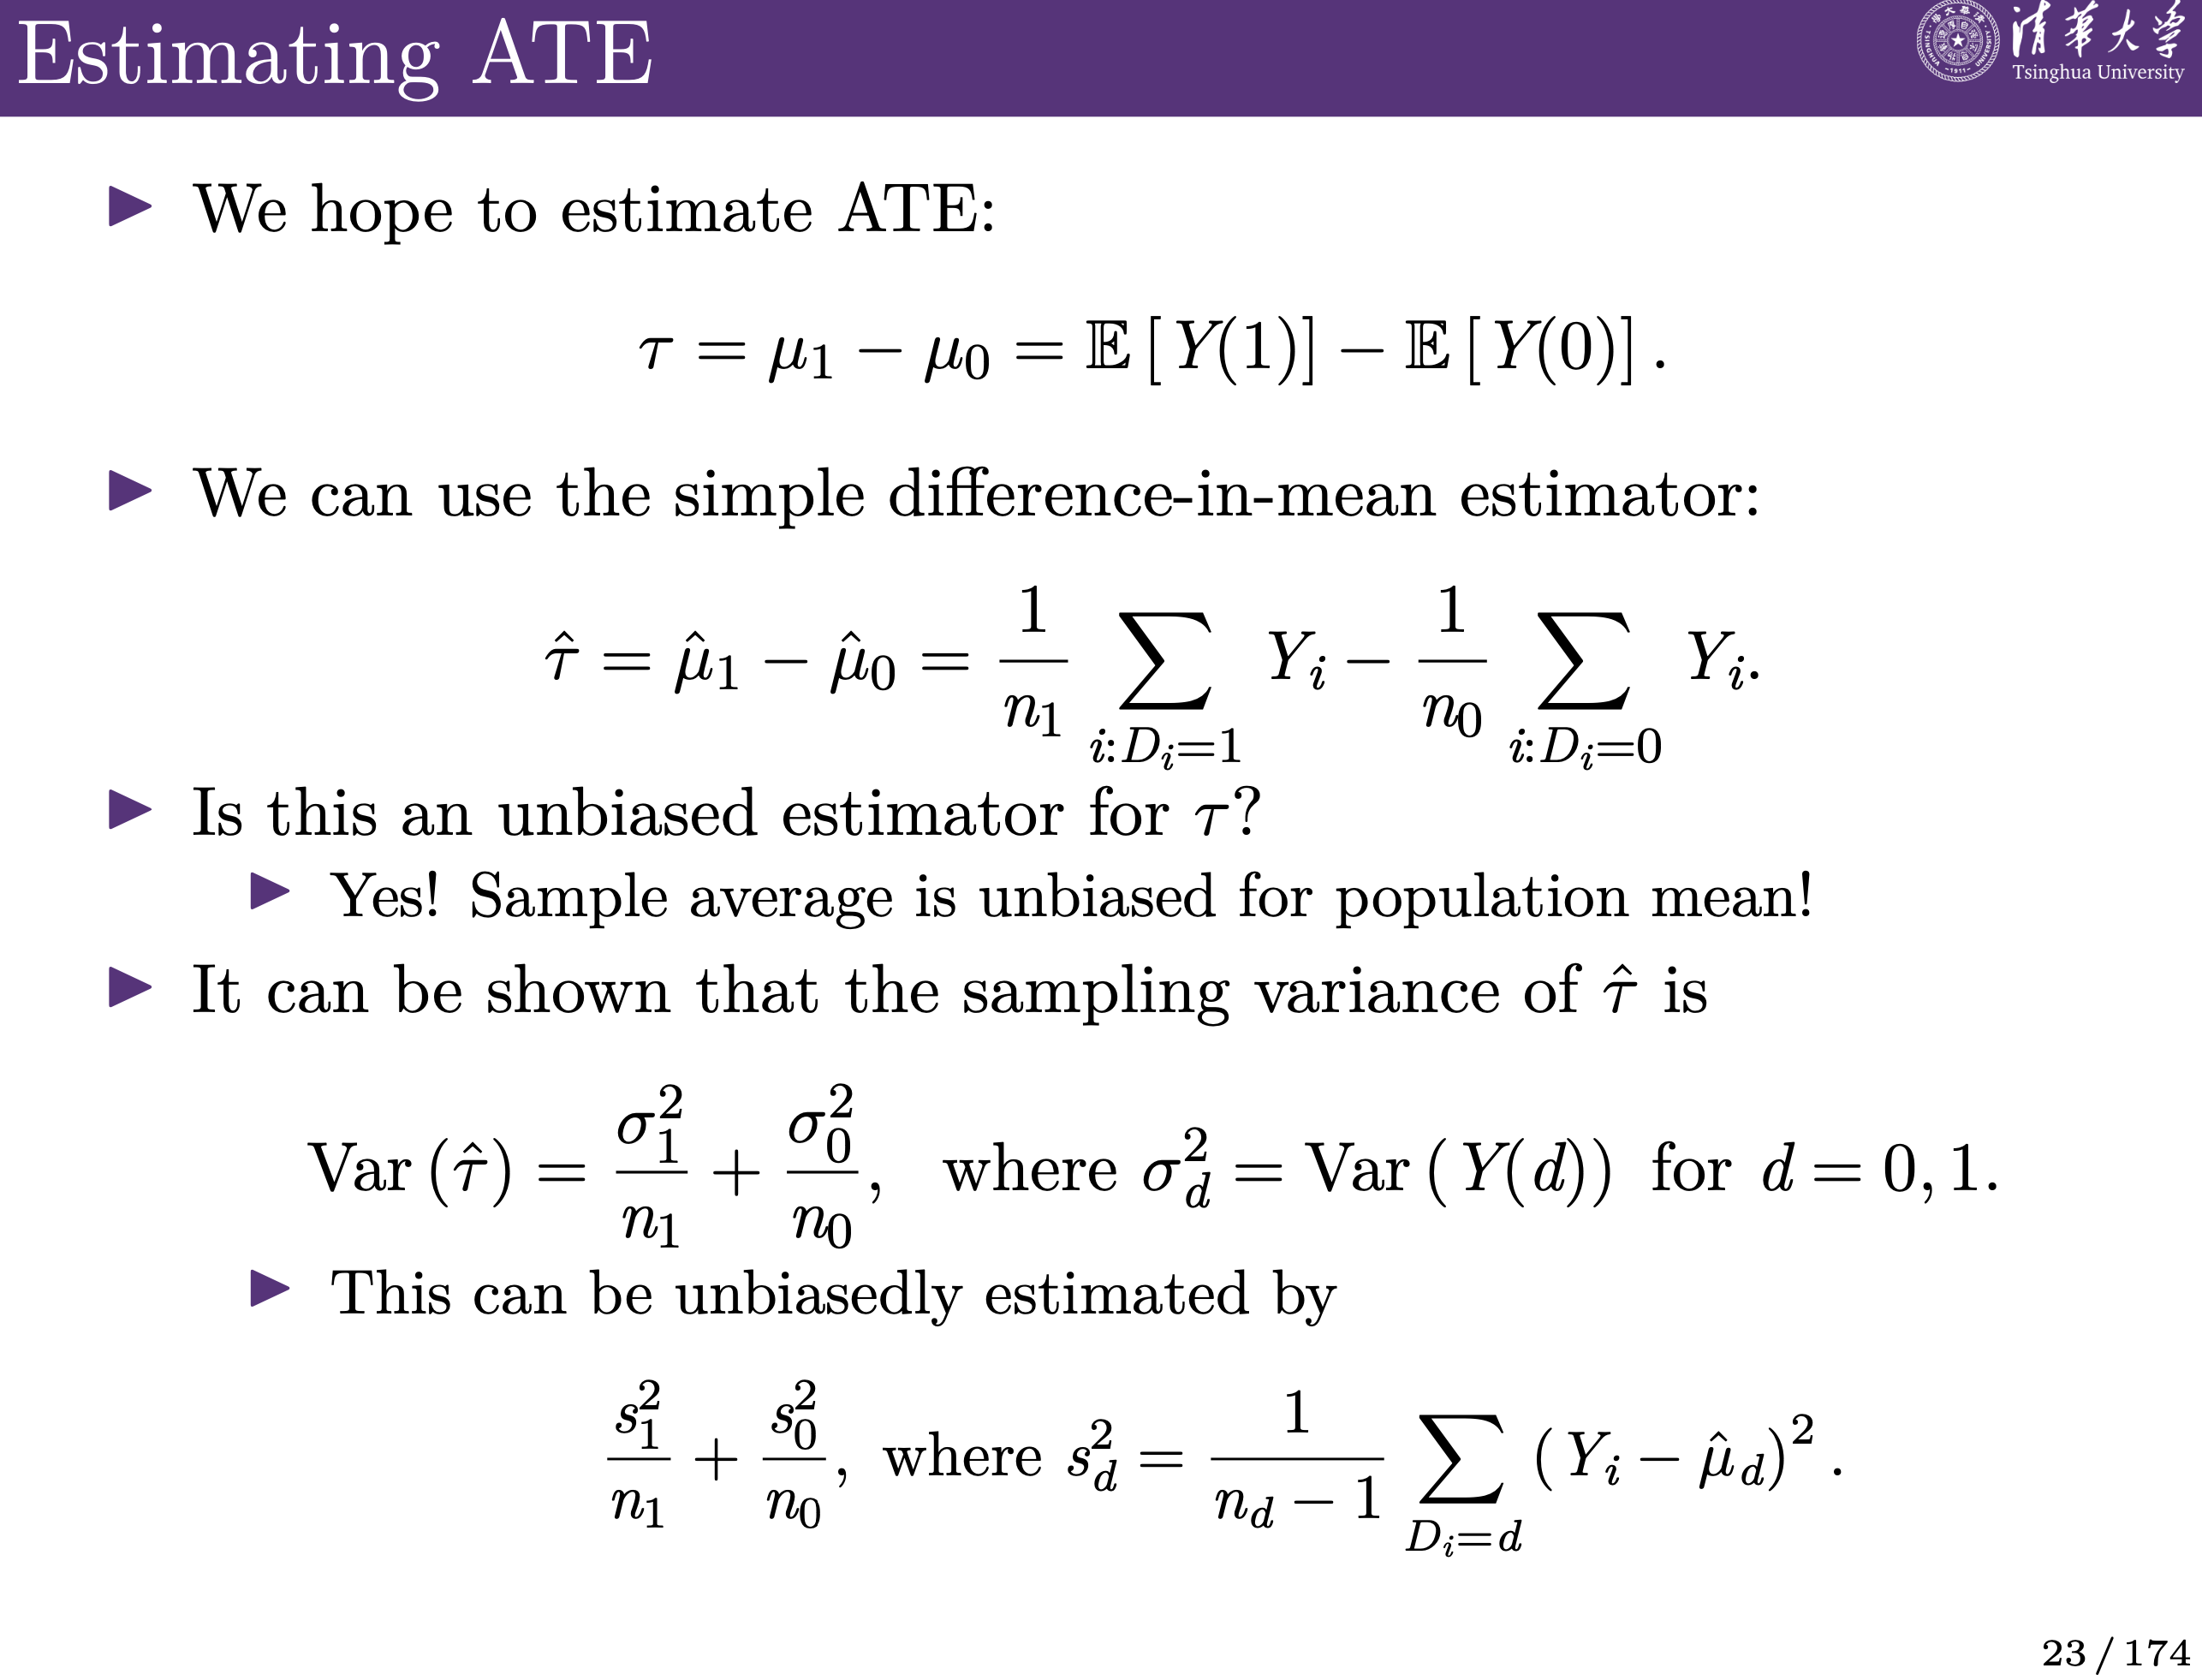

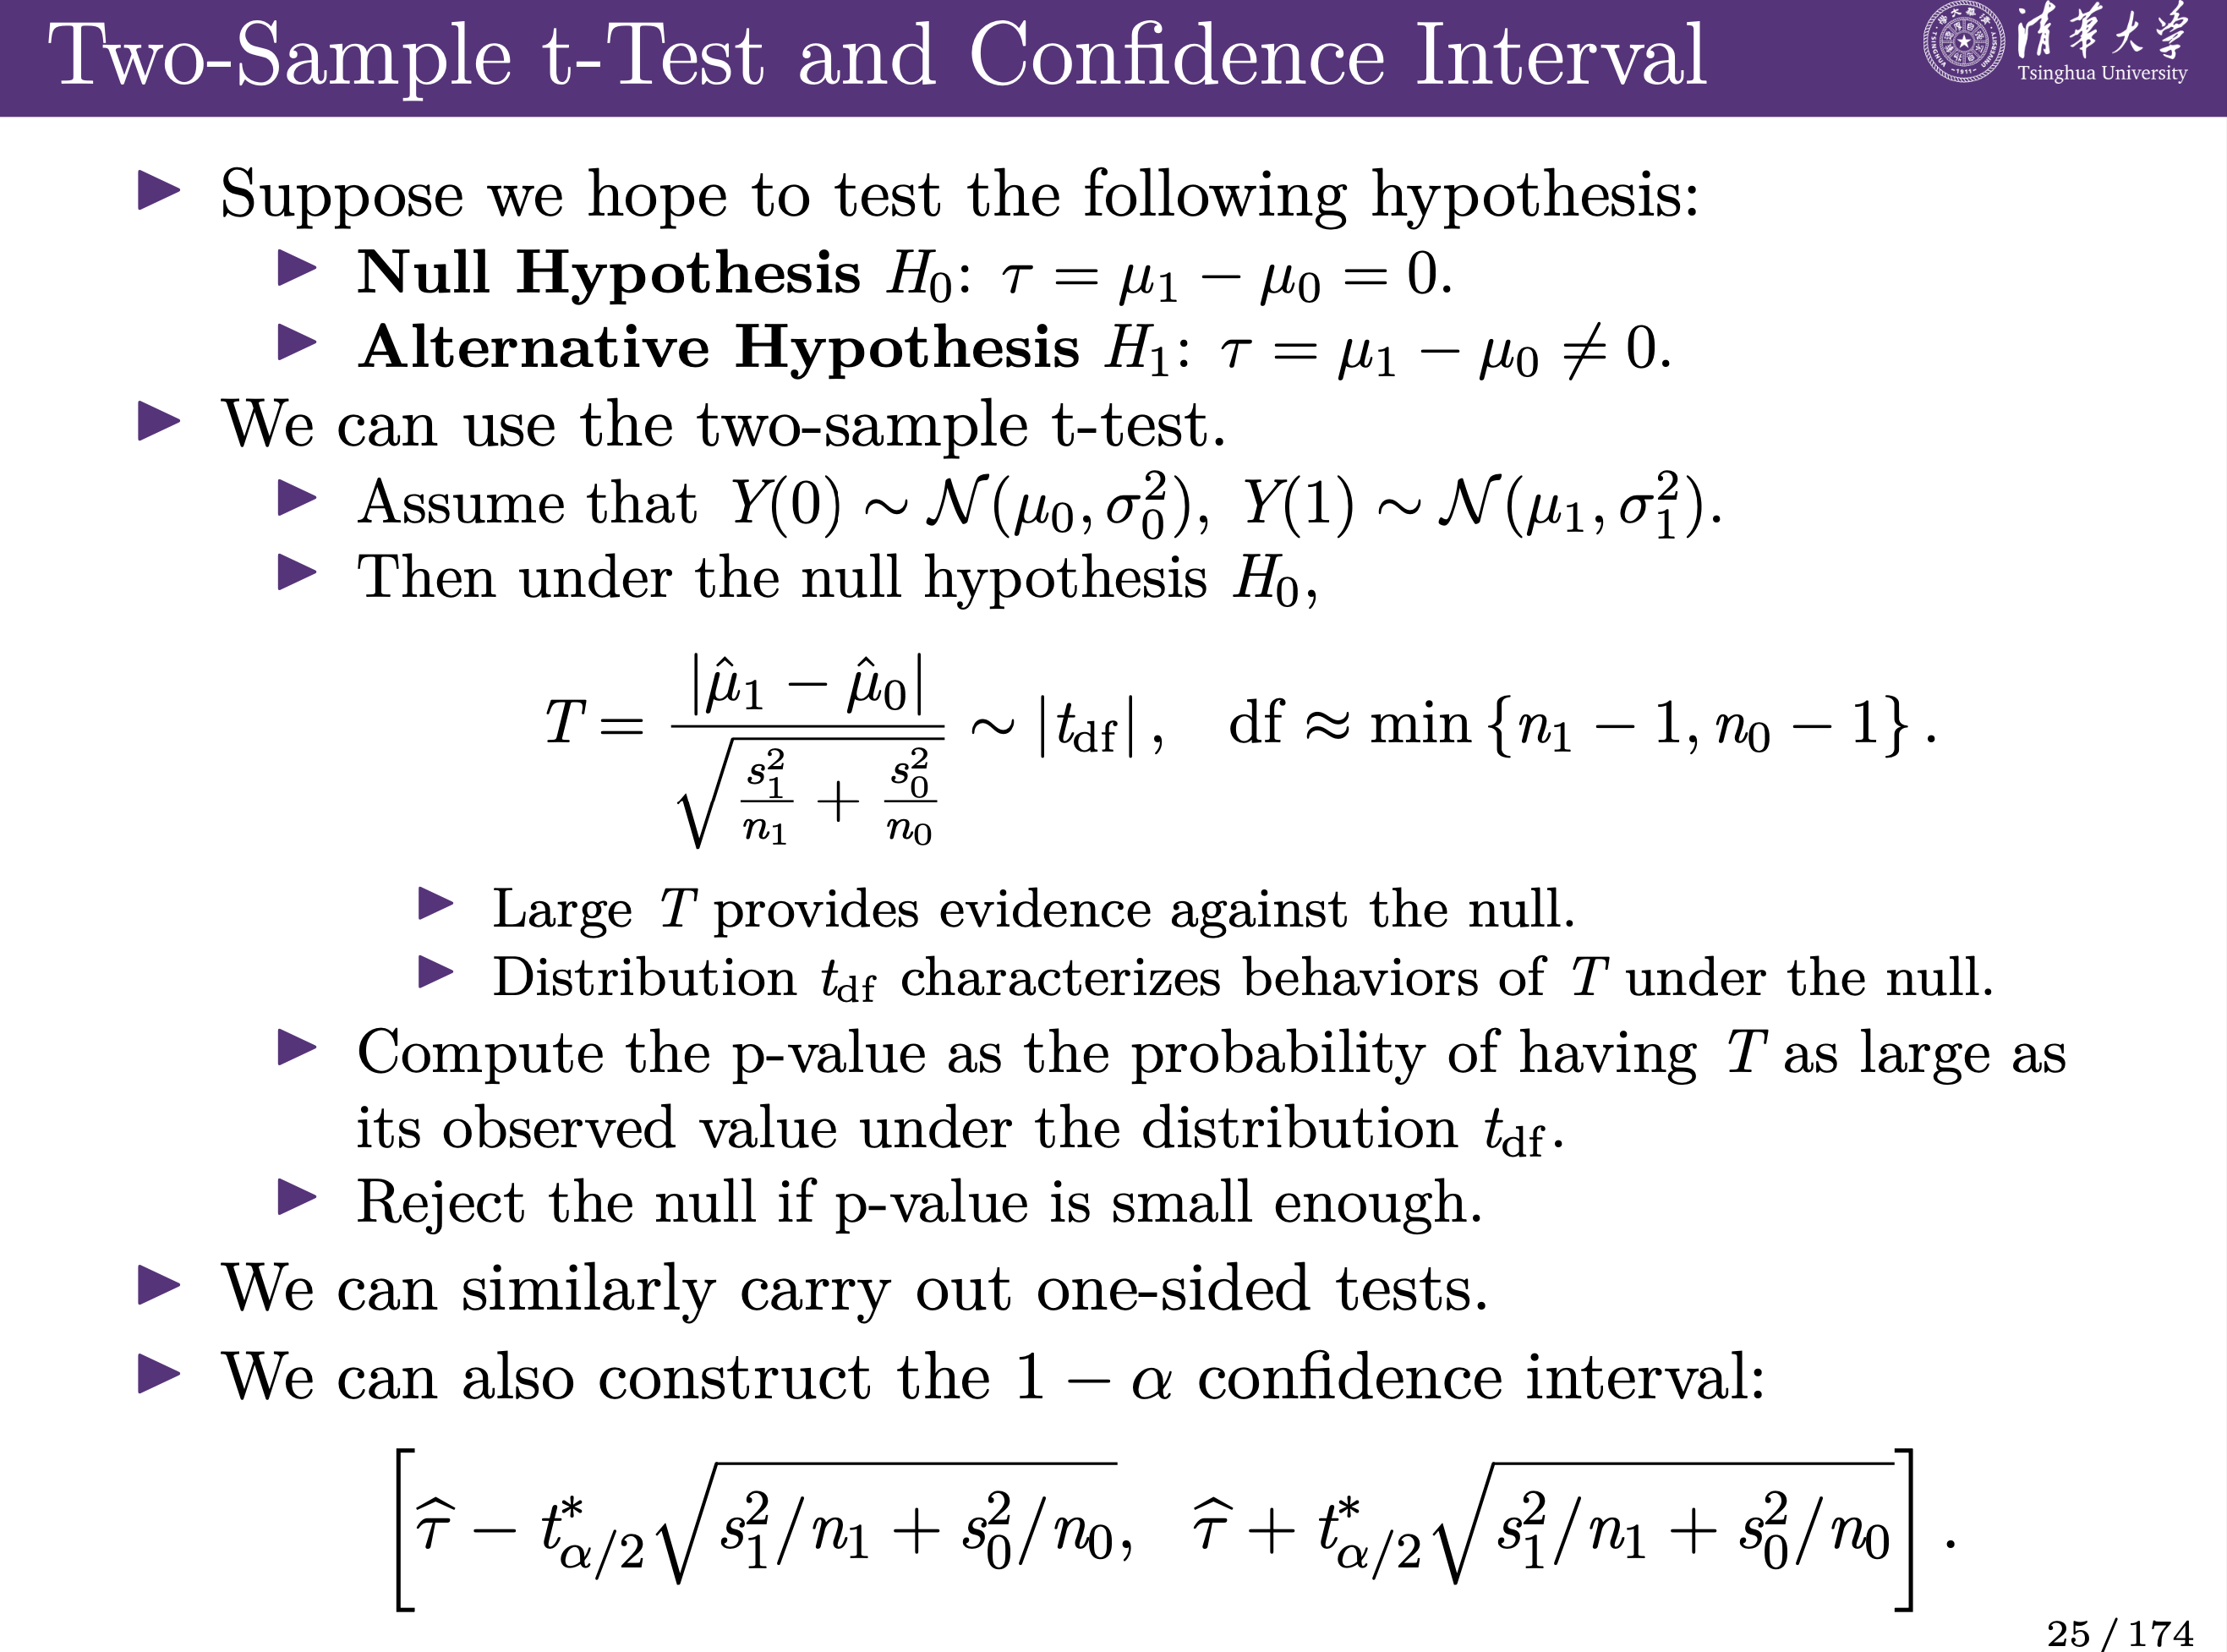

In [5]:
group_treat = data[data['guest_black']==1]["yes"].reset_index(drop=True)
group_control = data[data['guest_black']==0]["yes"].reset_index(drop=True)

In [6]:
treat_mean = group_treat.mean()
control_mean = group_control.mean()
diff_in_mean = treat_mean - control_mean
print("simple difference in mean: ", diff_in_mean)

simple difference in mean:  -0.07961289815350497


In [7]:
"""
def sem(data):
    n = len(data)
    s = np.std(data, ddof=1)  # ddof=1 表示使用样本标准差
    return s / np.sqrt(n)
"""

se_1 = stats.sem(group_treat)
se_0 = stats.sem(group_control)
se_diff = np.sqrt(se_1**2 + se_0**2)
confidence_level = 0.95
z = stats.norm.ppf(1-(1-confidence_level)/2) # Normal distribution临界值
ci_lower = diff_in_mean - z*se_diff
ci_upper = diff_in_mean + z*se_diff

# 计算p值
t_stat, p_value = stats.ttest_ind(group_treat, group_control, equal_var=False)
print("simple difference in mean: ", diff_in_mean)
print(f"95% CI: [{ci_lower}, {ci_upper}]")
print(f"p-value: {p_value}")

simple difference in mean:  -0.07961289815350497
95% CI: [-0.1042237777433738, -0.05500201856363615]
p-value: 2.4551121238500043e-10


In [8]:
# linear regression
import statsmodels.api as sm
X = data[["guest_black"]]
X = sm.add_constant(X)
y = data["yes"]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    yes   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     40.18
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           2.47e-10
Time:                        21:17:42   Log-Likelihood:                -4471.9
No. Observations:                6235   AIC:                             8948.
Df Residuals:                    6233   BIC:                             8961.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4878      0.009     55.242      

In [9]:
# data各列的type
type_list=data.dtypes
lst = type_list[type_list!="object"].index
lst = lst.difference(['super_host', 'number_of_messages', 'apt_rating', 'cleaning_fee', 'september_price', 'up_not_available_september', 'available_september'])
lst = lst.difference(["yes"])
lst = lst.difference(["guest_male", "guest_white","guest_race_continuous"]) #共线
print(len(lst))

# data用每列众数填充空值
data = data.fillna(data.mode().iloc[0])

65


In [10]:
# linear regression
import statsmodels.api as sm
X = data[lst].copy()
# X中心化zscore
X = (X - X.mean())  # centering 
X["guest_black"] = data["guest_black"]
X = sm.add_constant(X)
y = data["yes"]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    yes   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     12.56
Date:                Wed, 08 Jan 2025   Prob (F-statistic):          1.53e-119
Time:                        21:17:42   Log-Likelihood:                -4110.2
No. Observations:                6235   AIC:                             8350.
Df Residuals:                    6170   BIC:                             8788.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [11]:
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.4845,0.019,25.635,0.000,0.447,0.522
any_black,-0.0071,0.026,-0.272,0.786,-0.058,0.044
asian_proportion,0.4425,0.587,0.753,0.451,-0.709,1.594
asians,-6.338e-05,0.000,-0.469,0.639,-0.000,0.000
automated_coding,-0.0830,0.012,-6.781,0.000,-0.107,-0.059
baltimore,0.0629,2.316,0.027,0.978,-4.478,4.604
bathrooms,0.2629,0.142,1.847,0.065,-0.016,0.542
bedrooms,-0.0093,0.039,-0.242,0.809,-0.085,0.066
black_proportion,0.3128,0.567,0.552,0.581,-0.798,1.424
blacks,-2.351e-05,0.000,-0.181,0.857,-0.000,0.000


--------------------------------------------
## **(c)**
* Apply a `Double/Debiased Machine Learning (DML) method` (such as the partially linear
model or the double robust method) to estimate the average treatment effect. 
* Use at least `three` machine learning methods (e.g., Lasso, ridge, random forests, boosting, neural
nets) to estimate unknown nuisance functions in this process.
* `Compare` their results and discuss `why` DML may be useful even for `experimental data`.
--------------------------------

$$\begin{split}\begin{aligned} & Y = D\theta_0 + g_0(X) + \zeta, &\quad E[\zeta \mid D,X]= 0,\\ & D = m_0(X) + V, &\quad E[V \mid X] = 0. \end{aligned}\end{split}$$

In [12]:
# data各列的type
type_list=data.dtypes

In [13]:
type_list.value_counts()

float64    46
int64      30
object     28
Name: count, dtype: int64

In [14]:
type_list[type_list!="object"].index

Index(['number_of_messages', 'automated_coding', 'latitude', 'longitude',
       'number_guests', 'bedrooms', 'bathrooms', 'cleaning_fee', 'price',
       'apt_rating', 'listing_down', 'number_of_listings', 'number_of_reviews',
       'verified_id', 'super_host', 'guest_id', 'population', 'whites',
       'blacks', 'asians', 'hispanics', 'available_september',
       'up_not_available_september', 'september_price', 'host_id',
       'new_number_of_listings', 'response_date_stata', 'date_sent_stata',
       'guest_black', 'guest_white', 'guest_female', 'guest_male',
       'guest_race_continuous', 'host_race_black', 'host_race_white',
       'host_race_hisp', 'host_race_asian', 'host_race_mult', 'host_gender_F',
       'host_gender_FF', 'host_gender_M', 'host_gender_MM', 'host_gender_MF',
       'host_gender_same_sex', 'host_age_cat', 'ten_reviews',
       'five_star_property', 'multiple_listings', 'shared_property',
       'shared_bathroom', 'has_cleaning_fee', 'strict_cancellation', '

In [15]:
import numpy as np
import pandas as pd
import doubleml as dml
from doubleml.datasets import fetch_401K

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
data

,host_response,response_date,number_of_messages,automated_coding,latitude,longitude,bed_type,property_type,cancellation_policy,number_guests,...,los_angeles,sl,dc,total_guests,raw_black,prop_black,any_black,past_guest_merge,filled_september,pr_filled
0,Yes,2015-07-19 08:26:17,2.0,1.0,34.0815,-118.2700,Real Bed,House,Flexible,3.0,...,1,0,0,11.0,0.0,0.000000,0.0,matched (3),1,0.412335
1,No or unavailable,2015-07-14 14:13:39,2.0,1.0,38.9107,-77.0198,Real Bed,House,Moderate,2.0,...,0,0,1,167.0,0.0,0.000000,0.0,matched (3),1,0.686212
2,Request for more info (Can you verify? How man...,2015-07-20 16:24:08,2.0,0.0,34.0047,-118.4810,Pull-out Sofa,Apartment,Strict,1.0,...,1,0,0,19.0,0.0,0.000000,0.0,matched (3),0,0.330621
3,I will get back to you,2015-07-20 06:47:38,2.0,0.0,34.0917,-118.2820,Real Bed,House,Strict,8.0,...,1,0,0,41.0,0.0,0.000000,0.0,matched (3),0,0.535649
4,"Yes, if you verify/give more info",2015-07-18 18:07:19,2.0,0.0,34.0809,-118.3670,Real Bed,Apartment,Strict,3.0,...,1,0,0,263.0,1.0,0.003802,1.0,matched (3),1,0.855355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6230,Yes,2015-07-17 04:14:30,2.0,0.0,34.1737,-118.3440,Real Bed,House,Flexible,2.0,...,1,0,0,19.0,0.0,0.000000,0.0,matched (3),1,0.366860
6231,Check back later for definitive answer,2015-07-21 00:48:13,2.0,0.0,34.0428,-118.5620,Real Bed,House,Strict,9.0,...,1,0,0,1.0,0.0,0.000000,0.0,master only (1),0,0.292540
6232,Request for more info (Can you verify? How man...,2015-07-20 21:52:09,2.0,0.0,33.8766,-118.4020,Real Bed,Apartment,Flexible,6.0,...,1,0,0,6.0,0.0,0.000000,0.0,matched (3),0,0.396052
6233,Yes,2015-07-17 19:03:08,6.0,0.0,33.8679,-117.9230,Real Bed,House,Strict,4.0,...,1,0,0,10.0,1.0,0.100000,1.0,matched (3),1,0.323459


In [17]:
lst =  type_list[type_list!="object"].index
len(lst)

76

In [18]:
# data[lst]每列的空值率
data[lst].isnull().mean().sort_values(ascending=False).head(10)

super_host             1.0
number_of_messages     0.0
shared_bathroom        0.0
pricey                 0.0
old                    0.0
middle                 0.0
young                  0.0
strict_cancellation    0.0
has_cleaning_fee       0.0
shared_property        0.0
dtype: float64

In [19]:
lst = lst.difference(['super_host', 'number_of_messages', 'apt_rating', 'cleaning_fee', 'september_price', 'up_not_available_september', 'available_september'])
lst = lst.difference(["yes","guest_black","guest_race_continuous"])

lst = lst.to_list()

In [20]:
len(lst)

66

In [21]:
# data用每列众数填充空值
data = data.fillna(data.mode().iloc[0])

In [22]:
# Set up basic model: Specify variables for data-backend
features_base = lst

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_base= dml.DoubleMLData(data,
                                 y_col='yes',
                                 d_cols='guest_black',
                                 x_cols=features_base)

In [23]:
print("Used data:")
print(data_dml_base)

Used data:
================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: yes
Treatment variable(s): ['guest_black']
Covariates: ['any_black', 'asian_proportion', 'asians', 'automated_coding', 'baltimore', 'bathrooms', 'bedrooms', 'black_proportion', 'blacks', 'dallas', 'date_sent_stata', 'dc', 'filled_september', 'five_star_property', 'guest_female', 'guest_id', 'guest_male', 'guest_white', 'has_cleaning_fee', 'hispanic_proportion', 'hispanics', 'host_age_cat', 'host_gender_F', 'host_gender_FF', 'host_gender_M', 'host_gender_MF', 'host_gender_MM', 'host_gender_same_sex', 'host_id', 'host_race_asian', 'host_race_black', 'host_race_hisp', 'host_race_mult', 'host_race_white', 'latitude', 'listing_down', 'log_price', 'log_tract_listings', 'longitude', 'los_angeles', 'middle', 'multiple_listings', 'new_number_of_listings', 'number_guests', 'number_of_listings', 'number_of_reviews', 'old', 'population', 'pr_filled', 'pric

In [30]:
# Random Forest
randomForest = RandomForestRegressor(
    n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)
randomForest_class = RandomForestClassifier(
    n_estimators=500, max_depth=5, max_features=4, min_samples_leaf=7)

np.random.seed(123)
dml_plr_forest = dml.DoubleMLPLR(data_dml_base,
                                 ml_l = randomForest,
                                 ml_m = randomForest_class,
                                 n_folds = 3)
dml_plr_forest.fit(store_predictions=True)
forest_summary = dml_plr_forest.summary

forest_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
guest_black,-0.109217,0.023587,-4.63035,0.000004,-0.155448,-0.062987


In [26]:
# Boosted Trees
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror",
                     eta=0.1, n_estimators=35)
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss",
                            eta=0.1, n_estimators=34)

np.random.seed(123)
dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                ml_l = boost,
                                ml_m = boost_class,
                                n_folds = 3)
dml_plr_boost.fit(store_predictions=True)
boost_summary = dml_plr_boost.summary

boost_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
guest_black,-0.775343,0.348391,-2.225499,0.026048,-1.458176,-0.09251


In [27]:
# MLP
from sklearn.neural_network import MLPRegressor, MLPClassifier
mlp = MLPRegressor(hidden_layer_sizes=(64,64))
mlp_class = MLPRegressor(hidden_layer_sizes=(64,64))

np.random.seed(123)
dml_plr_mlp = dml.DoubleMLPLR(data_dml_base,
                              ml_l = mlp,
                              ml_m = mlp_class,
                              n_folds = 3)
dml_plr_mlp.fit(store_predictions=True)
mlp_summary = dml_plr_mlp.summary

mlp_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
guest_black,-1.50646,0.004338,-347.276846,0.0,-1.514962,-1.497957


In [31]:
plr_summary = pd.concat((forest_summary, boost_summary, mlp_summary))
plr_summary.index = [ 'forest', 'xgboost', 'mlp']
plr_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
forest,-0.109217,0.023587,-4.630350,0.000004,-0.155448,-0.062987
xgboost,-0.775343,0.348391,-2.225499,0.026048,-1.458176,-0.092510
mlp,-1.506460,0.004338,-347.276846,0.000000,-1.514962,-1.497957


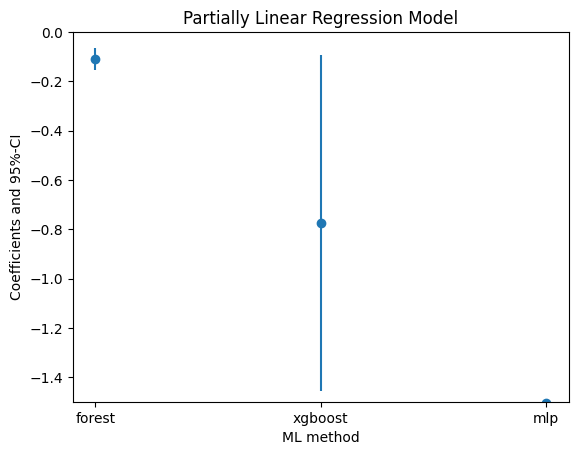

In [32]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
plt.errorbar(plr_summary.index, plr_summary.coef, fmt='o', yerr=errors)
plt.ylim([-1.5,0])

plt.title('Partially Linear Regression Model')
plt.xlabel('ML method')
_ =  plt.ylabel('Coefficients and 95%-CI')